In [ ]:

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import numpy as np
import time

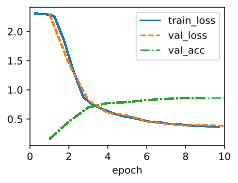

In [ ]:
#######
# NiN # #model1
#######

class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

NiN().layer_summary((1, 1, 224, 224))

start_time_nin = time.time()
model1 = NiN(lr=0.05)
trainer1 = d2l.Trainer(max_epochs=10, num_gpus=1)
model1.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer1.fit(model1, data)
end_time_nin = time.time()
duration_nin = end_time_nin - start_time_nin

In [ ]:
duration_nin

679.4290578365326

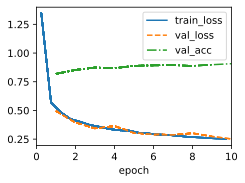

In [ ]:

#######
# NiN_FC #model2
#######

def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

class NiN_FC(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

start_time_nin_fc = time.time()
model2 = NiN_FC(lr=0.05)
trainer2 = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model2.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer2.fit(model2, data)
end_time_nin_fc = time.time()
duration_nin_fc = end_time_nin_fc - start_time_nin_fc

In [ ]:
duration_nin_fc

682.9838845729828

### Question 2

In [ ]:
train_loss1 = [model1.board.data['train_loss'][i][1] for i in range(10)]
val_acc1 = [model1.board.data['val_acc'][i][1] for i in range(10)]

train_loss2 = [model2.board.data['train_loss'][i][1] for i in range(10)]
val_acc2 = [model2.board.data['val_acc'][i][1] for i in range(10)]

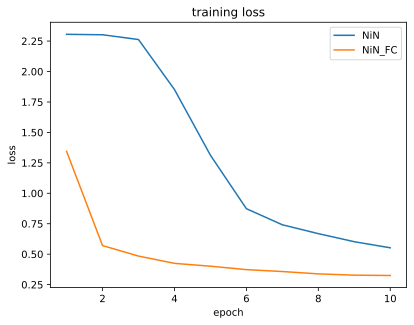

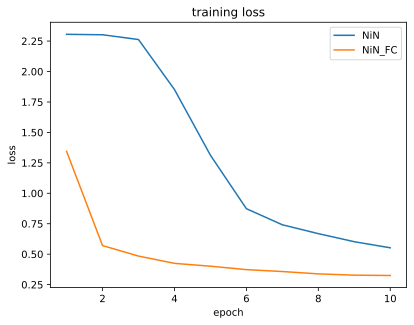

In [ ]:
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

#training loss
fig1, ax = plt.subplots()
x = np.linspace(1,10,10)
ax.plot(x, train_loss1, label='NiN')
ax.plot(x, train_loss2, label='NiN_FC')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('training loss')
ax.legend()
plt.show()

#validation accuracy
fig2, ax = plt.subplots()
x = np.linspace(1,10,10)
ax.plot(x, train_loss1, label='NiN')
ax.plot(x, train_loss2, label='NiN_FC')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('training loss')
ax.legend()
plt.show()

## section B


### Question 3


In [ ]:
@d2l.add_to_class(d2l.RNNLMScratch)
def predict_prob(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):          # i run from 0:25
        X = torch.tensor([[outputs[-1]]], device=device)  # X contain last entry of outputs
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            idx = torch.multinomial(F.softmax(Y[0,0,:]), 1)
            outputs.append(int(idx.reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

@d2l.add_to_class(d2l.RNNLMScratch)
def predict_max(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):          # i run from 0:25
        X = torch.tensor([[outputs[-1]]], device=device)  # X contain last entry of outputs
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

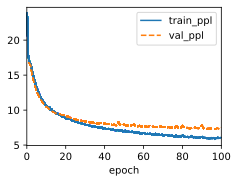

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = d2l.RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
#model.predict('it has', 20, data.vocab)

trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)

In [ ]:
print(model.predict_prob('it has', 30, data.vocab, d2l.try_gpu(i=1)))
print(model.predict_prob('it has', 30, data.vocab, d2l.try_gpu(i=1)))
print(model.predict_prob('it has', 30, data.vocab, d2l.try_gpu(i=1)))
print(model.predict_prob('it has', 30, data.vocab, d2l.try_gpu(i=1)))
print(model.predict_prob('it has', 30, data.vocab, d2l.try_gpu(i=1)))


it hasteansefonthourzyont atresstalr
it has or and omidourees of wravely 
it hastilly ho hengeremants onganes 
it hastoynstace ban of parcattancilr
it has ing pamitinby lacaviong of ca


<ipython-input-12-f64ef29b37b4>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  idx = torch.multinomial(F.softmax(Y[0,0,:]), 1)


In [ ]:
print(model.predict_max('it has', 30, data.vocab, d2l.try_gpu(i=1)))
print(model.predict_max('it has', 30, data.vocab, d2l.try_gpu(i=1)))
print(model.predict_max('it has', 30, data.vocab, d2l.try_gpu(i=1)))
print(model.predict_max('it has', 30, data.vocab, d2l.try_gpu(i=1)))
print(model.predict_max('it has', 30, data.vocab, d2l.try_gpu(i=1)))

it has of and of the pere the the th
it has of and of the pere the the th
it has of and of the pere the the th
it has of and of the pere the the th
it has of and of the pere the the th


(ii)
predict prob predicts the next token in the sequence based on the probabilities assigned to each token in the vocabulary. By considering the entire distribution, it captures the uncertainty in predictions, but may generate some less rational sentences.

predict_max predicts the next token by taking the token with the highest probability. It will generate more likely sentences, but may sometimes be meaningless ones due to the high frequency of the meaningless words.

## Section C


### Question 5

In [ ]:

class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)
    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs
    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        # print('output1', outputs)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # print('output2', outputs)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2SeqDecoder_greedy_search(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)
    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs
    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        context = context.repeat(1, 1, 1)
        outputs = []
        dec_input = torch.tensor([tgt_vocab['<bos>']])
        for i in range(embs.shape[0]):
            embs_and_context = torch.cat((dec_input, context), -1)
            Y, hidden_state = self.rnn(embs_and_context, hidden_state)
            outputs.append(Y)
            # embs_and_context = torch.cat((embs[i:i+1], context), -1)
            # Y, hidden_state = self.rnn(embs_and_context, hidden_state)
            # outputs.append(Y)
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        outputs = torch.cat(outputs,0)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [ ]:
#######################
# Machine Translation #
#######################

data = d2l.MTFraEng(batch_size=3)
raw_text = data._download()
print(raw_text[:48])

text = data._preprocess(raw_text)
print(text[:51])

src, tgt = data._tokenize(text)  # len(src), len(tgt): 167130
src[:4]
tgt[:4]

# Vocab for English
VocabE = data.src_vocab
VocabE.idx_to_token[:10]
len(VocabE.idx_to_token)  # 194

# Vocab for French
VocabF = data.tgt_vocab
VocabF.idx_to_token[:10]
len(VocabF.idx_to_token)  # 214

src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
src
tgt
src_valid_len
label
VocabE.to_tokens(src[0].type(torch.int32))
VocabF.to_tokens(tgt[0].type(torch.int32))

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !

go .	va !
hi .	salut !
run !	cours !
run !	courez !


['<bos>', "j'en", 'suis', '<unk>', '.', '<eos>', '<pad>', '<pad>', '<pad>']

In [ ]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(len(VocabE), embed_size, num_hiddens, num_layers, dropout)
decoder_teacher_forcing = Seq2SeqDecoder(len(VocabF), embed_size, num_hiddens, num_layers, dropout)
decoder_greedy_search = Seq2SeqDecoder_greedy_search(len(VocabF), embed_size, num_hiddens, num_layers, dropout)


NameError: name 'tgt_vocab' is not defined

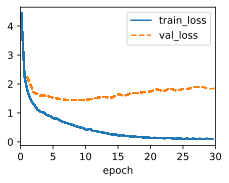

In [ ]:
#plot teacher forcing
model_teacher_forcing = d2l.Seq2Seq(encoder, decoder_teacher_forcing, lr=0.005, tgt_pad=data.tgt_vocab['<pad>'])
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model_teacher_forcing, data)
#plot greedy search
model_greedy_search = d2l.Seq2Seq(encoder, decoder_greedy_search, lr=0.005, tgt_pad=data.tgt_vocab['<pad>'])
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model_greedy_search, data)

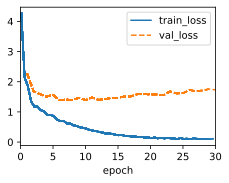

In [ ]:
###################################################
# Encoder-Decoder Seq2Seq for Machine Translation #
###################################################

embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
embed.weight                                 # learnable, generated from N(0,1)
x = torch.tensor([[1, 2, 3], [4, 5, 6]])     # just selecting rows 1 to 6
embed(x)

vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros(batch_size, num_steps)
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)
    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs
    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (num_steps, batch_size, num_hiddens))   # like enc_outputs
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))  # like enc_state

data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(len(VocabE), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(VocabF), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder,  lr=0.005, tgt_pad=data.tgt_vocab['<pad>'])
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(128, 10)

class Seq2SeqDecoder_greedy_search(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)
    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs
    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        context = context.unsqueeze(0)  # Fix: Add unsqueeze to match dimensions
        context = context.repeat(embs.shape[0], 1, 1)

        outputs = []
        dec_input = torch.tensor([tgt_vocab['<bos>']])
        for i in range(embs.shape[0]):
            embs_and_context = torch.cat((dec_input, context), -1)
            outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
            outputs = self.dense(outputs).swapaxes(0, 1)
            outputs.append(Y)
            # embs_and_context = torch.cat((embs[i:i+1], context), -1)
            # Y, hidden_state = self.rnn(embs_and_context, hidden_state)
            # outputs.append(Y)
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        outputs = torch.cat(outputs,0)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(len(VocabE), embed_size, num_hiddens, num_layers, dropout)
decoder_teacher_forcing = Seq2SeqDecoder(len(VocabF), embed_size, num_hiddens, num_layers, dropout)
decoder_greedy_search = Seq2SeqDecoder_greedy_search(len(VocabF), embed_size, num_hiddens, num_layers, dropout)

model_greedy_search = d2l.Seq2Seq(encoder, decoder_greedy_search, lr=0.005, tgt_pad=data.tgt_vocab['<pad>'])
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model_greedy_search, data)

RuntimeError: Tensors must have same number of dimensions: got 1 and 3

### Qustion 6
For training loss:
Teacher forcing decrease faster at the beginning, but may face challenge if right feedback is missing.
Previous prediction, though a lit bite slower in the decrease, has a robust pace, since it can learn from the previous experience.

For validation loss:
Teacher forcing won't decrease or may even increase the validation loss, because it has weaker generalized ability.
Previous prediction, still won't see fast decrease, but would perform better than teacher forcing as it learns.

## Session D

### Question 7

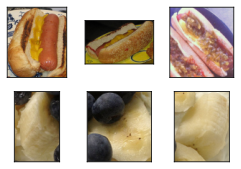

In [ ]:
import torchvision
import os

d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))
len(train_imgs)      # 2000
len(test_imgs)       # 800

# Show images of hotdogs and not hotdogs
hotdogs = [train_imgs[i][0] for i in range(3)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(3)]   # last three images
d2l.show_images(hotdogs + not_hotdogs, 2, 3, scale=1.4);

# Specify the means and standard deviations of e three RGB channels to standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Using the mean and std of Imagenet is a common practice. They are calculated
# based on millions of images. If you want to train from scratch on your own
# dataset, you can calculate the new mean and std. Otherwise, using Imagenet
# pretrained model with its own mean and std is recommended.

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(), normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(), normalize])


# If `param_group=True`, parameters in output layer are updated using learning rate 10 times greater



loss 0.380, train acc 0.833, test acc 0.855
1062.3 examples/sec on [device(type='cuda', index=0)]
param: Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],


'# Train from scratch\nscratch_net = torchvision.models.resnet18()  # did not specify pretrained=True\nscratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)\ntrain_fine_tuning(scratch_net, 5e-4, param_group=False) # same rate of 5e-4 for all parameters'

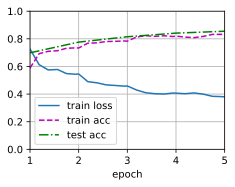

In [ ]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs), batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs), batch_size=batch_size)
    devices = d2l.try_all_gpus() #torch.device("cpu")
    loss = nn.CrossEntropyLoss(reduction="none")
    for name, param in net.named_parameters():
        if name not in ["fc.weight", "fc.bias"]:
            param.requires_grad = False
    # if param_group:
    #     params_1x = [param for name, param in net.named_parameters() # all parameters not in output layer
    #          if name not in ["fc.weight", "fc.bias"]]
    #     trainer = torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(),
    #               'lr': learning_rate * 10}], lr=learning_rate, weight_decay=0.001)
    # else:
    #     trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)

    trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
    # d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)

# Fine-tuning
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net.fc                                             # imagenet has 1000 classes
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)   # change no. of classes to 2
nn.init.xavier_uniform_(finetune_net.fc.weight);
# print("params:", finetune_net.parameters())
for param in finetune_net.parameters():
    print('param:', param)
train_fine_tuning(finetune_net, 5e-5)  # output layer lr: 5e-4, remaining lr: 5e-5
# print("params:", finetune_net.parameters())
for param in finetune_net.parameters():
    print('param:', param)

'''# Train from scratch
scratch_net = torchvision.models.resnet18()  # did not specify pretrained=True
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False) # same rate of 5e-4 for all parameters'''

loss 0.189, train acc 0.923, test acc 0.926
382.1 examples/sec on [device(type='cuda', index=0)]
param: Parameter containing:
tensor([[[[-9.6212e-03, -5.7344e-03, -1.6414e-03,  ...,  5.6584e-02,
            1.7160e-02, -1.2512e-02],
          [ 1.2466e-02,  1.0477e-02, -1.0923e-01,  ..., -2.7067e-01,
           -1.2836e-01,  4.6152e-03],
          [-5.6291e-03,  6.0033e-02,  2.9622e-01,  ...,  5.2021e-01,
            2.5696e-01,  6.4337e-02],
          ...,
          [-2.5911e-02,  1.7335e-02,  7.3772e-02,  ..., -3.3190e-01,
           -4.1972e-01, -2.5689e-01],
          [ 3.2076e-02,  4.2187e-02,  6.4054e-02,  ...,  4.1500e-01,
            3.9469e-01,  1.6718e-01],
          [-1.2442e-02, -2.6133e-03, -2.3040e-02,  ..., -1.4949e-01,
           -8.1005e-02, -4.5017e-03]],

         [[-1.0850e-02, -2.6868e-02, -3.5266e-02,  ...,  3.1488e-02,
           -5.0448e-04, -2.6897e-02],
          [ 4.6092e-02,  3.3157e-02, -1.0528e-01,  ..., -3.1360e-01,
           -1.6170e-01, -2.4378e-03],
 

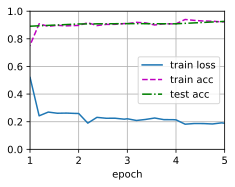

In [ ]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs), batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs), batch_size=batch_size)
    devices = d2l.try_all_gpus() #torch.device("cpu")
    loss = nn.CrossEntropyLoss(reduction="none")
    # for name, param in net.named_parameters():
    #     if name not in ["fc.weight", "fc.bias"]:
    #         param.requires_grad = False
    if param_group:
        params_1x = [param for name, param in net.named_parameters() # all parameters not in output layer
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(),
                  'lr': learning_rate * 10}], lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)

    trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)
    # d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)

    # Fine-tuning
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net.fc                                             # imagenet has 1000 classes
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)   # change no. of classes to 2
nn.init.xavier_uniform_(finetune_net.fc.weight);
# print("params:", finetune_net.parameters())
for param in finetune_net.parameters():
    print('param:', param)
train_fine_tuning(finetune_net, 5e-5)  # output layer lr: 5e-4, remaining lr: 5e-5
# print("params:", finetune_net.parameters())
for param in finetune_net.parameters():
    print('param:', param)


In [ ]:
# Suppose we have weight parameters for the "hotdog" class in the ImageNet dataset
hotdog_params = ...

# Initialize a new model for fine-tuning with pre-trained parameters for the "hotdog" class
finetune_hotdog_net = torchvision.models.resnet18(pretrained=False)
finetune_hotdog_net.fc = nn.Linear(finetune_hotdog_net.fc.in_features, 2)
finetune_hotdog_net.fc.weight.data.copy_(hotdog_params)

# Set learning rate and number of epochs
learning_rate = 5e-5
num_epochs = 5

# Train the model with pre-trained parameters for the "hotdog" class
train_fine_tuning_v2(finetune_hotdog_net, learning_rate, num_epochs=num_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


TypeError: copy_(): argument 'other' (position 1) must be Tensor, not ellipsis

### Question 8

we can apply the hot-dog classification experience into our new task, which is transfer learning. We initialize the weights of the new output layer and fine tuning backward. To prevent updating parameters prior to the output layer during training, set the requires_grad attribute of these parameters to False. this ensures that only the parameters of the output layer are updated during training.